In [1]:
import pandas as pd
from geographiclib.geodesic import Geodesic
import geopandas
from geographiclib.geodesic import Geodesic
import math
import folium
geod = Geodesic.WGS84 

data = 'obc_tanker_cargo.csv'
df = pd.read_csv(data)
df.shape

(131308, 23)

In [2]:
df['BEAM'] = df['DIM_PORT'] + df['DIM_STARBOARD']
df['LENGTH'] = df['DIM_BOW'] + df['DIM_STERN']
df = df[df['BEAM'] > 0]
df = df[df['LENGTH'] > 0]
df = df[df['DRAUGHT'] > 0]
df.shape

(127770, 25)

In [3]:
df = df[df['NAV_STATUS'] == 0]
df.shape

(125355, 25)

In [4]:
df = df[df['SPEED_KNOTS'] > 3]
df.shape

(124600, 25)

In [5]:
df['MMSI'].nunique()

3522

In [6]:
df['PERIOD'] = pd.to_datetime(df['PERIOD'])
df['DATE'] = df['PERIOD'].dt.date
df['TIME'] = df['PERIOD'].dt.time
df['CHANNEL_SIDE'] = ['Northwestbound' if x > 200 else 'Southeastbound' for x in df['COG_DEG']]

In [7]:
df = df.sort_values(['MMSI', 'PERIOD'])
df['time_diff'] = (df.groupby('MMSI')['PERIOD'].diff().dt.total_seconds())

threshold = 3 * 3600
df['new_voyage'] = (df['time_diff'] > threshold)
df['voyage_id'] = (df.groupby('MMSI')['new_voyage'].cumsum()+1)
df

,MSG_TYPE,MMSI,NAME,IMO_NUMBER,CALL_SIGN,LAT_AVG,LON_AVG,PERIOD,SPEED_KNOTS,COG_DEG,...,MMSI_COUNTRY_CD,RECEIVER,BEAM,LENGTH,DATE,TIME,CHANNEL_SIDE,time_diff,new_voyage,voyage_id
116677,1,205042000,DELOS,9877767.0,ONKR,22.736758,-78.616947,2023-06-04 14:00:00,13.0,110.0,...,BE,rEV02,60,336,2023-06-04,14:00:00,Southeastbound,NaN,False,1
116686,1,205042000,DELOS,9877767.0,ONKR,22.707576,-78.536280,2023-06-04 14:20:00,13.1,111.2,...,BE,rEV02,60,336,2023-06-04,14:20:00,Southeastbound,1200.0,False,1
116687,1,205042000,DELOS,9877767.0,ONKR,22.705818,-78.531350,2023-06-04 14:25:00,13.1,111.3,...,BE,rEV02,60,336,2023-06-04,14:25:00,Southeastbound,300.0,False,1
116698,1,205042000,DELOS,9877767.0,ONKR,22.666790,-78.419349,2023-06-04 14:55:00,13.3,110.4,...,BE,rEV02,60,336,2023-06-04,14:55:00,Southeastbound,1800.0,False,1
116703,1,205042000,DELOS,9877767.0,ONKR,22.654898,-78.384704,2023-06-04 15:05:00,13.4,110.2,...,BE,rEV02,60,336,2023-06-04,15:05:00,Southeastbound,600.0,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102529,1,720202000,INTL VICTORY,8977766.0,CPA3027,23.360848,-78.953454,2024-10-28 21:30:00,7.0,342.5,...,BO,NaN,12,33,2024-10-28,21:30:00,Northwestbound,26100.0,True,25
102530,1,720202000,INTL VICTORY,8977766.0,CPA3027,23.364144,-78.954727,2024-10-28 21:35:00,6.9,346.9,...,BO,NaN,12,33,2024-10-28,21:35:00,Northwestbound,300.0,False,25
102854,1,720202000,INTL VICTORY,8977766.0,CPA3027,22.251636,-77.465667,2024-11-15 21:30:00,6.3,130.8,...,BO,NaN,12,33,2024-11-15,21:30:00,Southeastbound,1554900.0,True,26
102859,1,720202000,INTL VICTORY,8977766.0,CPA3027,22.009253,-77.023147,2024-11-16 02:10:00,6.3,116.5,...,BO,NaN,12,33,2024-11-16,02:10:00,Southeastbound,16800.0,True,27


In [8]:
ping_counts = (df.groupby(['MMSI', 'voyage_id']).size().reset_index(name='num_pings'))
ping_counts.sort_values(['num_pings'])

,MMSI,voyage_id,num_pings
30,205681000,10,1
25,205681000,5,1
23,205681000,3,1
15992,720202000,24,1
9548,477162100,1,1
...,...,...,...
13667,636020073,1,148
13145,636016672,1,151
12354,563758000,7,153
949,219466000,2,158


In [9]:
sus_vessel = df[df['MMSI']==353054000]
sus_vessel = sus_vessel[sus_vessel['voyage_id']==4]
sus_vessel

,MSG_TYPE,MMSI,NAME,IMO_NUMBER,CALL_SIGN,LAT_AVG,LON_AVG,PERIOD,SPEED_KNOTS,COG_DEG,...,MMSI_COUNTRY_CD,RECEIVER,BEAM,LENGTH,DATE,TIME,CHANNEL_SIDE,time_diff,new_voyage,voyage_id
49417,1,353054000,BALSA 94,9800855.0,H9TG,22.980534,-79.336711,2024-02-24 00:05:00,11.3,110.9,...,PA,rORBCOMM999,19,106,2024-02-24,00:05:00,Southeastbound,7666800.0,True,4
49418,1,353054000,BALSA 94,9800855.0,H9TG,22.974169,-79.318125,2024-02-24 00:10:00,11.2,109.9,...,PA,rORBCOMM999,19,106,2024-02-24,00:10:00,Southeastbound,300.0,False,4
49419,1,353054000,BALSA 94,9800855.0,H9TG,22.968548,-79.301316,2024-02-24 00:15:00,11.3,110.4,...,PA,rORBCOMM999,19,106,2024-02-24,00:15:00,Southeastbound,300.0,False,4
49421,1,353054000,BALSA 94,9800855.0,H9TG,22.963040,-79.283819,2024-02-24 00:20:00,11.3,108.8,...,PA,rORBCOMM999,19,106,2024-02-24,00:20:00,Southeastbound,300.0,False,4
49422,1,353054000,BALSA 94,9800855.0,H9TG,22.957961,-79.267942,2024-02-24 00:25:00,11.3,109.5,...,PA,rORBCOMM999,19,106,2024-02-24,00:25:00,Southeastbound,300.0,False,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50763,1,353054000,BALSA 94,9800855.0,H9TG,21.716168,-76.892965,2024-02-24 14:00:00,11.2,115.9,...,PA,rORBCOMM999,19,106,2024-02-24,14:00:00,Southeastbound,300.0,False,4
50778,1,353054000,BALSA 94,9800855.0,H9TG,21.708614,-76.876192,2024-02-24 14:05:00,11.1,116.1,...,PA,rORBCOMM999,19,106,2024-02-24,14:05:00,Southeastbound,300.0,False,4
50781,1,353054000,BALSA 94,9800855.0,H9TG,21.701391,-76.860013,2024-02-24 14:10:00,11.1,115.4,...,PA,rORBCOMM999,19,106,2024-02-24,14:10:00,Southeastbound,300.0,False,4
50797,1,353054000,BALSA 94,9800855.0,H9TG,21.694136,-76.843530,2024-02-24 14:15:00,11.0,115.3,...,PA,rORBCOMM999,19,106,2024-02-24,14:15:00,Southeastbound,300.0,False,4


In [10]:
data = pd.read_csv('obc_boundaries_plus.csv')
from shapely.geometry import Point
from shapely.geometry import Polygon
data = data[data['Line']!='Middle']
data['geometry'] = data.apply(lambda x: (float(x.Long), float(x.Lat)), axis=1)

channel_coords = list(data['geometry'])
channel_coords_reorder = [channel_coords[0], channel_coords[1], channel_coords[2], channel_coords[3], channel_coords[-1], channel_coords[-2], channel_coords[-3], channel_coords[-4]]
channel_polygon = Polygon(channel_coords_reorder)
geo_df_channel = geopandas.GeoDataFrame(geometry=[channel_polygon], crs='EPSG:4326')

In [11]:
geo_df_sus_vessel = geopandas.GeoDataFrame(sus_vessel, geometry=geopandas.points_from_xy(sus_vessel['LON_AVG'], sus_vessel['LAT_AVG']), crs='EPSG:4326')

In [12]:
def where_is_vessel(LAT_AVG, LON_AVG, BOOL):
    if BOOL == True:
        answer = 'in channel'
    elif LON_AVG < -78.72296667:
        answer = 'west'
    elif LON_AVG > -77.49385:
        answer = 'east'
    elif LAT_AVG > 22.84101667:
        answer = 'north'
    elif LAT_AVG < 22.12445:
        answer = 'south'
    else:
        answer = 'other'
    return answer
    

In [13]:
geo_df_sus_vessel['in_channel'] = geo_df_sus_vessel.within(channel_polygon)
geo_df_sus_vessel['location'] = geo_df_sus_vessel.apply(lambda x: where_is_vessel(x.LAT_AVG, x.LON_AVG, x.in_channel), axis=1)
geo_df_sus_vessel.head()

,MSG_TYPE,MMSI,NAME,IMO_NUMBER,CALL_SIGN,LAT_AVG,LON_AVG,PERIOD,SPEED_KNOTS,COG_DEG,...,LENGTH,DATE,TIME,CHANNEL_SIDE,time_diff,new_voyage,voyage_id,geometry,in_channel,location
49417,1,353054000,BALSA 94,9800855.0,H9TG,22.980534,-79.336711,2024-02-24 00:05:00,11.3,110.9,...,106,2024-02-24,00:05:00,Southeastbound,7666800.0,True,4,POINT (-79.33671 22.98053),False,west
49418,1,353054000,BALSA 94,9800855.0,H9TG,22.974169,-79.318125,2024-02-24 00:10:00,11.2,109.9,...,106,2024-02-24,00:10:00,Southeastbound,300.0,False,4,POINT (-79.31812 22.97417),False,west
49419,1,353054000,BALSA 94,9800855.0,H9TG,22.968548,-79.301316,2024-02-24 00:15:00,11.3,110.4,...,106,2024-02-24,00:15:00,Southeastbound,300.0,False,4,POINT (-79.30132 22.96855),False,west
49421,1,353054000,BALSA 94,9800855.0,H9TG,22.963040,-79.283819,2024-02-24 00:20:00,11.3,108.8,...,106,2024-02-24,00:20:00,Southeastbound,300.0,False,4,POINT (-79.28382 22.96304),False,west
49422,1,353054000,BALSA 94,9800855.0,H9TG,22.957961,-79.267942,2024-02-24 00:25:00,11.3,109.5,...,106,2024-02-24,00:25:00,Southeastbound,300.0,False,4,POINT (-79.26794 22.95796),False,west


In [14]:
df_unique_full = df.drop_duplicates(subset='MMSI').copy()
df_unique_full['first_three'] = (df_unique_full['MMSI'].astype(str).str[:3].astype(int))

In [15]:
df_unique_full.sort_values(['first_three'])
print(df_unique_full['first_three'].value_counts())

first_three
538    685
636    596
477    198
563    191
352    136
      ... 
622      1
642      1
632      1
626      1
668      1
Name: count, Length: 105, dtype: int64


In [16]:
geo_df_sus_vessel_clean = geo_df_sus_vessel['geometry']
geo_df_sus_vessel['in_channel'].value_counts()


in_channel
False    86
True     81
Name: count, dtype: int64

In [17]:
my_map = folium.Map(location=[22.5, -77.8], zoom_start=11)
folium.GeoJson(geo_df_channel).add_to(my_map)
folium.GeoJson(geo_df_sus_vessel_clean).add_to(my_map)
my_map

<Axes: >

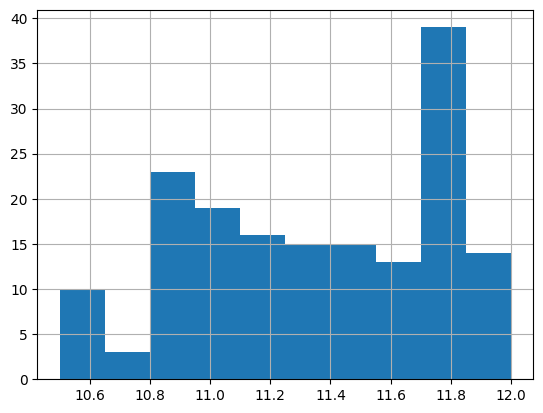

In [18]:
geo_df_sus_vessel['SPEED_KNOTS'].hist()

In [19]:
geo_df_vessels = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df['LON_AVG'], df['LAT_AVG']), crs='EPSG:4326')
geo_df_vessels['in_channel'] = geo_df_vessels.within(channel_polygon)
geo_df_vessels['location'] = geo_df_vessels.apply(lambda x: where_is_vessel(x.LAT_AVG, x.LON_AVG, x.in_channel), axis=1)
geo_df_vessels.head()

,MSG_TYPE,MMSI,NAME,IMO_NUMBER,CALL_SIGN,LAT_AVG,LON_AVG,PERIOD,SPEED_KNOTS,COG_DEG,...,LENGTH,DATE,TIME,CHANNEL_SIDE,time_diff,new_voyage,voyage_id,geometry,in_channel,location
116677,1,205042000,DELOS,9877767.0,ONKR,22.736758,-78.616947,2023-06-04 14:00:00,13.0,110.0,...,336,2023-06-04,14:00:00,Southeastbound,NaN,False,1,POINT (-78.61695 22.73676),True,in channel
116686,1,205042000,DELOS,9877767.0,ONKR,22.707576,-78.536280,2023-06-04 14:20:00,13.1,111.2,...,336,2023-06-04,14:20:00,Southeastbound,1200.0,False,1,POINT (-78.53628 22.70758),True,in channel
116687,1,205042000,DELOS,9877767.0,ONKR,22.705818,-78.531350,2023-06-04 14:25:00,13.1,111.3,...,336,2023-06-04,14:25:00,Southeastbound,300.0,False,1,POINT (-78.53135 22.70582),True,in channel
116698,1,205042000,DELOS,9877767.0,ONKR,22.666790,-78.419349,2023-06-04 14:55:00,13.3,110.4,...,336,2023-06-04,14:55:00,Southeastbound,1800.0,False,1,POINT (-78.41935 22.66679),True,in channel
116703,1,205042000,DELOS,9877767.0,ONKR,22.654898,-78.384704,2023-06-04 15:05:00,13.4,110.2,...,336,2023-06-04,15:05:00,Southeastbound,600.0,False,1,POINT (-78.3847 22.6549),True,in channel


In [20]:
geo_df_vessels['location'].value_counts()

location
in channel    61513
east          38325
west          24394
north           298
other            57
south            13
Name: count, dtype: int64

In [21]:
weird_vessels = geo_df_vessels[geo_df_vessels['location']!='in channel']
weird_vessels = weird_vessels[geo_df_vessels['location']!='east']
weird_vessels = weird_vessels[geo_df_vessels['location']!='west']

c:\Users\LAKwon\anaconda3\envs\capstone\Lib\site-packages\geopandas\geodataframe.py:1891: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
c:\Users\LAKwon\anaconda3\envs\capstone\Lib\site-packages\geopandas\geodataframe.py:1891: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


In [22]:
weird_vessels.head()
weird_vessels_clean = weird_vessels[['geometry']]

In [23]:
m = folium.Map(location=[22.5, -77.8], zoom_start=11)
weird_vessels["PERIOD"] = weird_vessels['PERIOD'].astype(str)
folium.GeoJson(geo_df_channel).add_to(m)
folium.GeoJson(weird_vessels_clean).add_to(m)
m

In [24]:
df_unique = weird_vessels.drop_duplicates(subset='MMSI').copy()
df_unique['first_three'] = (df_unique['MMSI'].astype(str).str[:3].astype(int))

In [ ]:
df_unique.head()

,MSG_TYPE,MMSI,NAME,IMO_NUMBER,CALL_SIGN,LAT_AVG,LON_AVG,PERIOD,SPEED_KNOTS,COG_DEG,...,DATE,TIME,CHANNEL_SIDE,time_diff,new_voyage,voyage_id,geometry,in_channel,location,first_three
112861,1,255806086,SONDERBORG,9454242.0,CQIW4,22.108671,-77.500992,2023-05-21 19:40:00,14.4,131.8,...,2023-05-21,19:40:00,Southeastbound,900.0,False,10,POINT (-77.50099 22.10867),False,south,255
96398,1,255915644,SEABOARD GARDENIA,9673630.0,CQ2102,22.900053,-78.710780,2025-06-03 02:50:00,17.9,328.8,...,2025-06-03,02:50:00,Northwestbound,2700.0,False,27,POINT (-78.71078 22.90005),False,north,255
20938,1,271048264,KPS GULTEKIN BEY,9002049.0,TCA6188,22.014700,-77.520189,2023-03-08 18:20:00,6.2,150.2,...,2023-03-08,18:20:00,Southeastbound,3600.0,False,2,POINT (-77.52019 22.0147),False,south,271
14533,1,304813000,SINAA,9081318.0,V2IG4,22.920255,-78.707775,2023-02-15 14:40:00,16.3,324.0,...,2023-02-15,14:40:00,Northwestbound,7800.0,False,6,POINT (-78.70778 22.92026),False,north,304
2692,1,304941000,DENEB,9344241.0,V2BW1,22.930755,-78.692354,2023-04-08 19:20:00,14.0,325.9,...,2023-04-08,19:20:00,Northwestbound,300.0,False,10,POINT (-78.69235 22.93076),False,north,304


In [36]:
df.columns

Index(['MSG_TYPE', 'MMSI', 'NAME', 'IMO_NUMBER', 'CALL_SIGN', 'LAT_AVG',
       'LON_AVG', 'PERIOD', 'SPEED_KNOTS', 'COG_DEG', 'HEADING_DEG',
       'NAV_STATUS', 'NAV_SENSOR', 'SHIP_AND_CARGO_TYPE', 'DRAUGHT',
       'DRAUGHT.1', 'DIM_BOW', 'DIM_STERN', 'DIM_PORT', 'DIM_STARBOARD',
       'DESTINATION', 'MMSI_COUNTRY_CD', 'RECEIVER', 'BEAM', 'LENGTH', 'DATE',
       'TIME', 'CHANNEL_SIDE', 'time_diff', 'new_voyage', 'voyage_id'],
      dtype='object')

In [ ]:
df_routes = df[['MMSI', 'LAT_AVG', 'LON_AVG', 'DATE', 'TIME', 'SPEED_KNOTS', 'COG_DEG', 'HEADING_DEG']]
df_routes['DATETIME'] = pd.to_datetime(df_routes['DATE'].astype(str) + ' ' + df_routes['TIME'].astype(str))

df_routes.drop(columns=['TIME', 'DATE'])


C:\Users\LAKwon\AppData\Local\Temp\ipykernel_11404\937069219.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_routes['DATETIME'] = pd.to_datetime(


,MMSI,LAT_AVG,LON_AVG,SPEED_KNOTS,COG_DEG,HEADING_DEG,DATETIME
116677,205042000,22.736758,-78.616947,13.0,110.0,111.0,2023-06-04 14:00:00
116686,205042000,22.707576,-78.536280,13.1,111.2,112.0,2023-06-04 14:20:00
116687,205042000,22.705818,-78.531350,13.1,111.3,112.0,2023-06-04 14:25:00
116698,205042000,22.666790,-78.419349,13.3,110.4,111.0,2023-06-04 14:55:00
116703,205042000,22.654898,-78.384704,13.4,110.2,111.0,2023-06-04 15:05:00
...,...,...,...,...,...,...,...
102529,720202000,23.360848,-78.953454,7.0,342.5,NaN,2024-10-28 21:30:00
102530,720202000,23.364144,-78.954727,6.9,346.9,NaN,2024-10-28 21:35:00
102854,720202000,22.251636,-77.465667,6.3,130.8,NaN,2024-11-15 21:30:00
102859,720202000,22.009253,-77.023147,6.3,116.5,NaN,2024-11-16 02:10:00


In [77]:
df_routes.dtypes

MMSI                    int64
LAT_AVG               float64
LON_AVG               float64
DATE                   object
TIME                   object
SPEED_KNOTS           float64
COG_DEG               float64
HEADING_DEG           float64
DATETIME       datetime64[ns]
dtype: object

In [78]:
df_routes.sort_values('MMSI')

,MMSI,LAT_AVG,LON_AVG,DATE,TIME,SPEED_KNOTS,COG_DEG,HEADING_DEG,DATETIME
116677,205042000,22.736758,-78.616947,2023-06-04,14:00:00,13.0,110.0,111.0,2023-06-04 14:00:00
116686,205042000,22.707576,-78.536280,2023-06-04,14:20:00,13.1,111.2,112.0,2023-06-04 14:20:00
116687,205042000,22.705818,-78.531350,2023-06-04,14:25:00,13.1,111.3,112.0,2023-06-04 14:25:00
116698,205042000,22.666790,-78.419349,2023-06-04,14:55:00,13.3,110.4,111.0,2023-06-04 14:55:00
116703,205042000,22.654898,-78.384704,2023-06-04,15:05:00,13.4,110.2,111.0,2023-06-04 15:05:00
...,...,...,...,...,...,...,...,...,...
102529,720202000,23.360848,-78.953454,2024-10-28,21:30:00,7.0,342.5,NaN,2024-10-28 21:30:00
102530,720202000,23.364144,-78.954727,2024-10-28,21:35:00,6.9,346.9,NaN,2024-10-28 21:35:00
102854,720202000,22.251636,-77.465667,2024-11-15,21:30:00,6.3,130.8,NaN,2024-11-15 21:30:00
102859,720202000,22.009253,-77.023147,2024-11-16,02:10:00,6.3,116.5,NaN,2024-11-16 02:10:00


In [79]:
df_routes['MMSI'].nunique()

3522

In [96]:
first_vessel = df_routes['MMSI'][0]

df_first_vessel = df_routes[df_routes['MMSI'] == first_vessel]
df_first_vessel = df_first_vessel.sort_values(['DATETIME'])
df_first_vessel['DELTA_SECONDS'] = df_first_vessel['DATETIME'].diff().dt.total_seconds()
df_first_vessel.head()

time_cutoff = 2*24*60*60
df_first_vessel['NEW_TRACK_CHECK'] = ((df_first_vessel['DELTA_SECONDS'] >= 1200))
df_first_vessel['TRACK_COUNT'] = df_first_vessel['NEW_TRACK_CHECK'].cumsum()
df_first_vessel.head(10)

,MMSI,LAT_AVG,LON_AVG,DATE,TIME,SPEED_KNOTS,COG_DEG,HEADING_DEG,DATETIME,DELTA_SECONDS,NEW_TRACK_CHECK,TRACK_COUNT
10891,323150000,21.722616,-76.801300,2023-01-27,15:40:00,15.6,293.0,293.0,2023-01-27 15:40:00,NaN,False,0
10894,323150000,21.733550,-76.830034,2023-01-27,15:45:00,15.7,291.0,293.0,2023-01-27 15:45:00,300.0,False,0
10898,323150000,21.746600,-76.862384,2023-01-27,15:55:00,15.8,294.0,296.0,2023-01-27 15:55:00,600.0,False,0
10903,323150000,22.020708,-77.273292,2023-01-27,17:40:00,15.6,310.5,312.0,2023-01-27 17:40:00,6300.0,True,1
10905,323150000,22.027291,-77.281575,2023-01-27,17:45:00,15.4,310.5,314.0,2023-01-27 17:45:00,300.0,False,1
10908,323150000,22.041916,-77.299067,2023-01-27,17:50:00,15.2,311.0,315.0,2023-01-27 17:50:00,300.0,False,1
10909,323150000,22.104058,-77.373992,2023-01-27,18:10:00,15.3,314.5,320.0,2023-01-27 18:10:00,1200.0,True,2
10913,323150000,22.136350,-77.409933,2023-01-27,18:20:00,15.4,313.0,316.0,2023-01-27 18:20:00,600.0,False,2
10918,323150000,22.187860,-77.471033,2023-01-27,18:40:00,15.0,310.3,313.0,2023-01-27 18:40:00,1200.0,True,3
10924,323150000,22.286316,-77.589258,2023-01-27,19:15:00,15.0,313.0,315.0,2023-01-27 19:15:00,2100.0,True,4


In [ ]:
m = folium.Map(location=[22.5, -77.8], zoom_start=9)
weird_vessels["PERIOD"] = weird_vessels['PERIOD'].astype(str)
folium.GeoJson(geo_df_channel).add_to(m)
folium.GeoJson(weird_vessels_clean).add_to(m)
m